### Contents

[Imports](#Imports)

[bottom](#bottom)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pprint import pprint
import sys 
import json 
import itertools 
from tqdm import tqdm
from datetime import datetime, date, timedelta
from load_dotenv import load_dotenv
load_dotenv() # OPENAI_API_KEY

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, clear_output
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

---

In [4]:
import openai
from openai import OpenAI

In [5]:
# os.environ['OPENAI_API_KEY'] = 'xxxx'

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt4o-mini.csv')
print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")
df.head()

df: 1,830 x 5


,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [7]:
df = df.iloc[:300].reset_index(drop=True)
print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")

df: 300 x 5


### Q1. Getting the embeddings model

Now, get the embeddings model multi-qa-mpnet-base-dot-v1 from the Sentence Transformer library

Note: this is not the same model as in HW3

```python
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)
```

Create the embeddings for the first LLM answer:

```python
answer_llm = df.iloc[0].answer_llm
```

What's the first value of the resulting vector?

- -0.42
- -0.22
- -0.02
- 0.21

In [6]:
from sentence_transformers import SentenceTransformer
model_name = 'multi-qa-mpnet-base-dot-v1'
embedding_model = SentenceTransformer(model_name)
embedding_model

/Users/antonandreytsev/llm_zoomcamp_venv3.9.7/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [8]:
answer_llm = df.iloc[0].answer_llm
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [10]:
embedding_model.encode(answer_llm)[0]

-0.42244658

### Q2. Computing the dot product

Now for each answer pair, let's create embeddings and compute dot product between them

We will put the results (scores) into the evaluations list

What's the 75% percentile of the score?

- 21.67
- 31.67
- 41.67
- 51.67

In [93]:
answer_llm_ebs = embedding_model.encode(df['answer_llm'].values, batch_size=128, show_progress_bar=True)
answer_orig_ebs = embedding_model.encode(df['answer_orig'].values, batch_size=128, show_progress_bar=True)
print(f"answer_llm_ebs: {answer_llm_ebs.shape[0]:,} x {answer_llm_ebs.shape[1]:,}")
print(f"answer_orig_ebs: {answer_orig_ebs.shape[0]:,} x {answer_orig_ebs.shape[1]:,}")

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches: 100%|██████████| 3/3 [00:14<00:00,  4.94s/it]


answer_llm_ebs: 300 x 768
answer_orig_ebs: 300 x 768


In [94]:
dot_products = []
for llm, orig in tqdm(zip(answer_llm_ebs, answer_orig_ebs)):
    dot_products.append(llm @ orig)
print(len(dot_products))

300it [00:00, 10767.33it/s]

300


<Axes: ylabel='Density'>

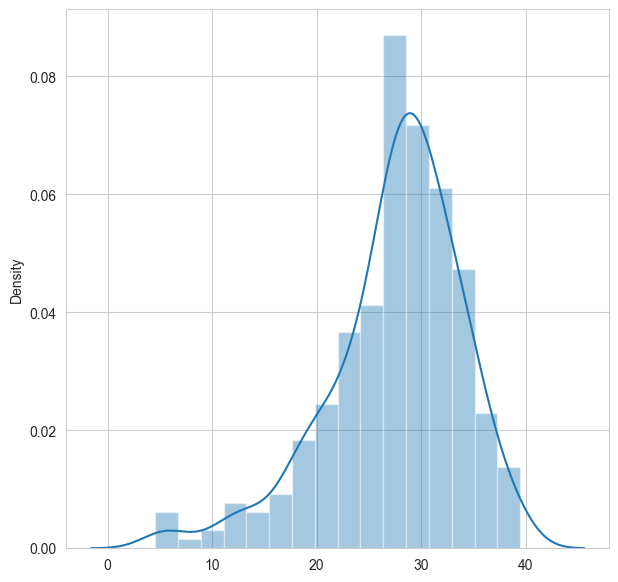

In [95]:
sns.distplot(dot_products)

In [96]:
np.quantile(dot_products, 0.75)

31.674301624298096

### Q3. Computing the cosine

From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we

Compute the norm of a vector
Divide each element by this norm
So, for vector v, it'll be v / ||v||

In numpy, this is how you do it:

```python
norm = np.sqrt((v * v).sum())
v_norm = v / norm
```

Let's put it into a function and then compute dot product between normalized vectors. This will give us cosine similarity

What's the 75% cosine in the scores?

- 0.63
- 0.73
- 0.83
- 0.93

In [97]:
answer_llm_ebs_norm = answer_llm_ebs / np.linalg.norm(answer_llm_ebs, axis=1).reshape(-1, 1)
answer_orig_ebs_norm = answer_orig_ebs / np.linalg.norm(answer_orig_ebs, axis=1).reshape(-1, 1)
assert np.allclose(np.linalg.norm(answer_llm_ebs_norm, axis=1), 1.0)
assert np.allclose(np.linalg.norm(answer_orig_ebs_norm, axis=1), 1.0)
print(f"answer_llm_ebs_norm: {answer_llm_ebs_norm.shape[0]:,} x {answer_llm_ebs_norm.shape[1]:,}")
print(f"answer_orig_ebs_norm: {answer_orig_ebs_norm.shape[0]:,} x {answer_orig_ebs_norm.shape[1]:,}")

answer_llm_ebs_norm: 300 x 768
answer_orig_ebs_norm: 300 x 768


In [98]:
cosine_products = []
for llm, orig in tqdm(zip(answer_llm_ebs_norm, answer_orig_ebs_norm)):
    cosine_products.append(llm @ orig)
print(len(cosine_products))

300it [00:00, 683482.46it/s]

300


<Axes: ylabel='Density'>

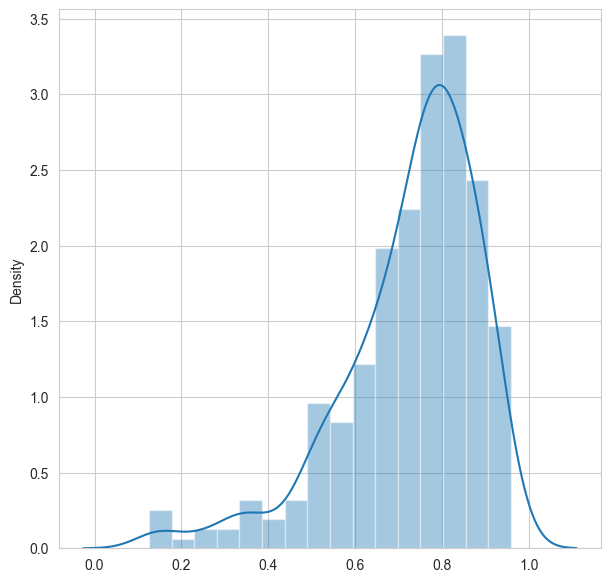

In [99]:
sns.distplot(cosine_products)

In [100]:
np.quantile(cosine_products, 0.75)

0.8362347334623337

### Q4. Rouge

Now we will explore an alternative metric - the ROUGE score.

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

```bash
pip install rouge
```

(The latest version at the moment of writing is 1.0.1)

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (doc_id=5170565b)

```python
from rouge import Rouge
rouge_scorer = Rouge()
scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]
```

There are three scores: rouge-1, rouge-2 and rouge-l, and precision, recall and F1 score for each.

rouge-1 - the overlap of unigrams,
rouge-2 - bigrams,
rouge-l - the longest common subsequence
What's the F score for rouge-1?

- 0.35
- 0.45
- 0.55
- 0.65

In [109]:
llm, orig = df.loc[(df['document'] == '5170565b')].loc[10][['answer_llm', 'answer_orig']].values
print(llm)
print(orig)

Yes, all sessions are recorded, so if you miss one, you won't miss anything. You can catch up on the content later. Additionally, you can submit your questions in advance for office hours, and those sessions are also recorded.
Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.


In [111]:
from rouge import Rouge
rouge_scorer = Rouge()
scores = rouge_scorer.get_scores(llm, orig)[0]
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

### Q5. Average rouge score

Let's compute the average between rouge-1, rouge-2 and rouge-l for the same record from Q4

- 0.35
- 0.45
- 0.55
- 0.65

In [112]:
(0.45454544954545456 + 0.21621621121621637 + 0.393939388939394) / 3

0.35490034990035496

### Q6. Average rouge score for all the data points

Now let's compute the score for all the records

```python
rouge_1 = scores['rouge-1']['f']
rouge_2 = scores['rouge-2']['f']
rouge_l = scores['rouge-l']['f']
rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
```

And create a dataframe from them

What's the agerage rouge_2 across all the records?

- 0.10
- 0.20
- 0.30
- 0.40

In [126]:
from rouge import Rouge

rouge_scorer = Rouge()
scores = []
for llm, orig in df[['answer_llm', 'answer_orig']].itertuples(index=False):
    scores.append(rouge_scorer.get_scores(llm, orig)[0])

In [125]:
rouge_1 = np.array([score['rouge-1']['f'] for score in scores])
rouge_2 = np.array([score['rouge-2']['f'] for score in scores])
rouge_l = np.array([score['rouge-l']['f'] for score in scores])
rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
print(np.mean(rouge_2))

0.20696501983423318


### bottom